In [121]:
import tensorboard as tb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from packaging import version
from scipy import stats
from scipy.interpolate import Rbf
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.4.0


In [95]:
# # for cartpole
# ENV_NAMES = ['Random Noise', 'Random Action', 'Sign Flipping', 'exp1']
# experiment_ids = ["tKqRKDX5TDe6ul26NYl4VQ", "iObYJ5NWSqqG1GsrZVddHA", "dwrilEMzQAKWcZQ20g9EOQ", 'N6T4MvXPQRCEvamXGNS7Mg']


# for lunarlander - to run
ENV_NAMES = ['Random Noise', 'Random Action', 'Sign Flipping', 'exp1']
experiment_ids = ["RDbXEyNARwSQvvWvQGAAjA", "IGTLX5DsRPys4LwmkOrbEA", "AZXbDLxzRX6qeYBMZ0dhYg", 'IMRJlvZNTjqGEOMy7gvqiA','SNEA3ywGQR6BdqNbwE5Nmw']


# # for half-cheetah
# ENV_NAMES = ['Random Noise', 'Random Action', 'Sign Flipping', 'exp1']
# experiment_ids = ["LwWJaUQbR6iAVkKfO3TY8A", "IOogeXQlRUm9iOoZcemUVg", "ZoBb1ummQ7GFYuB2jhDriw", 'ehAu5EPfRMeEQgvt1FBMHQ']



experiments = []
dfs = []
for experiment_id in experiment_ids:
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    experiments.append(experiment)
    dfs.append(experiment.get_scalars())
    


# Train or Validate?

In [96]:
dfws = []
for idx_, experiment in enumerate(experiments):
    dfw = experiment.get_scalars(pivot=False)
    dfw = dfw[dfw.tag.str.startswith("validate/total")]
#     if idx_ == 2:
#         dfw = dfw[dfw.run.str.contains("W10B3-SF_20210126T1350")]# filter the discarded runs for cartpole only!
    dfws.append(dfw)
    

In [97]:
dfws[0] = pd.concat([dfws[0], dfws[3][dfws[3].run.str.contains('VPG')]])

temp = dfws[3][dfws[3].run.str.contains('SVRG') & (dfws[3].tag.str.contains('_0') | dfws[3].tag.str.contains('_1') | dfws[3].tag.str.contains('_2'))]
temp = temp.replace("validate/total_rewards_0","validate/total_rewards_9")
temp = temp.replace('validate/total_rewards_1','validate/total_rewards_8')
temp = temp.replace('validate/total_rewards_2','validate/total_rewards_7')

dfws[0] = pd.concat([dfws[0], temp])


In [98]:
dfws[0] = dfws[0].replace('LunarLander-v2/worker10_byzantine3_random-noise/Exp3_LunarLander_Ours_W10B3_RN_20210209T105541',
               'LunarLander-v2/worker10_byzantine3_random-noise/Exp3_LunarLander_Ours_W10B3_RN_20210209T105548')

dfws[0] = dfws[0].replace('LunarLander-v2/worker10_byzantine3_random-noise/Exp3_LunarLander_Ours_W10B3_RN_20210209T105558',
               'LunarLander-v2/worker10_byzantine3_random-noise/Exp3_LunarLander_Ours_W10B3_RN_20210209T105548')

dfws[0] = dfws[0].replace('LunarLander-v2/worker10_byzantine3_random-noise/NEW_Exp2_LunarLander_SVRG_W10B3-RN_20210202T064727',
                          'LunarLander-v2/worker10_byzantine3_random-noise/Exp3_LunarLander_SVRG_W10B3_RN_20210209T105608')


dfws[1] = dfws[1].replace('LunarLander-v2/worker10_byzantine3_random-action/Exp3_LunarLander_Ours_W10B3_RA_20210206T230512',
               'LunarLander-v2/worker10_byzantine3_random-action/Exp3_LunarLander_Ours_W10B3_RA_20210206T230517')

dfws[1] = dfws[1].replace('LunarLander-v2/worker10_byzantine3_random-action/Exp3_LunarLander_Ours_W10B3_RA_20210206T230520',
                          'LunarLander-v2/worker10_byzantine3_random-action/Exp3_LunarLander_Ours_W10B3_RA_20210206T230517')
        
dfws[2] = dfws[2].replace('LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110101',
               'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110050')

dfws[2] = dfws[2].replace('LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110040',
                          'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110050')
        
             
        
dfws[2].run.unique()

array(['LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110050',
       'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_SVRG_W10B3_SF_20210209T110116',
       'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_VPG_W10B3_SF_20210209T110123'],
      dtype=object)

# Plot configurations


In [99]:
################# CartPole, LunarLander, HalfCheetah
# max_trajectories_ls = [int(5e3), int(5e3), int(5e3)]
max_trajectories_ls = [int(1e4), int(1e4), int(1e4)]
max_runs = 9
interval = 0.90

In [103]:
dfws[2].run.unique()

array(['LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_Ours_W10B3_SF_20210209T110050',
       'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_SVRG_W10B3_SF_20210209T110116',
       'LunarLander-v2/worker10_byzantine3_sign-flipping/Exp3_LunarLander_VPG_W10B3_SF_20210209T110123'],
      dtype=object)

# Plot!

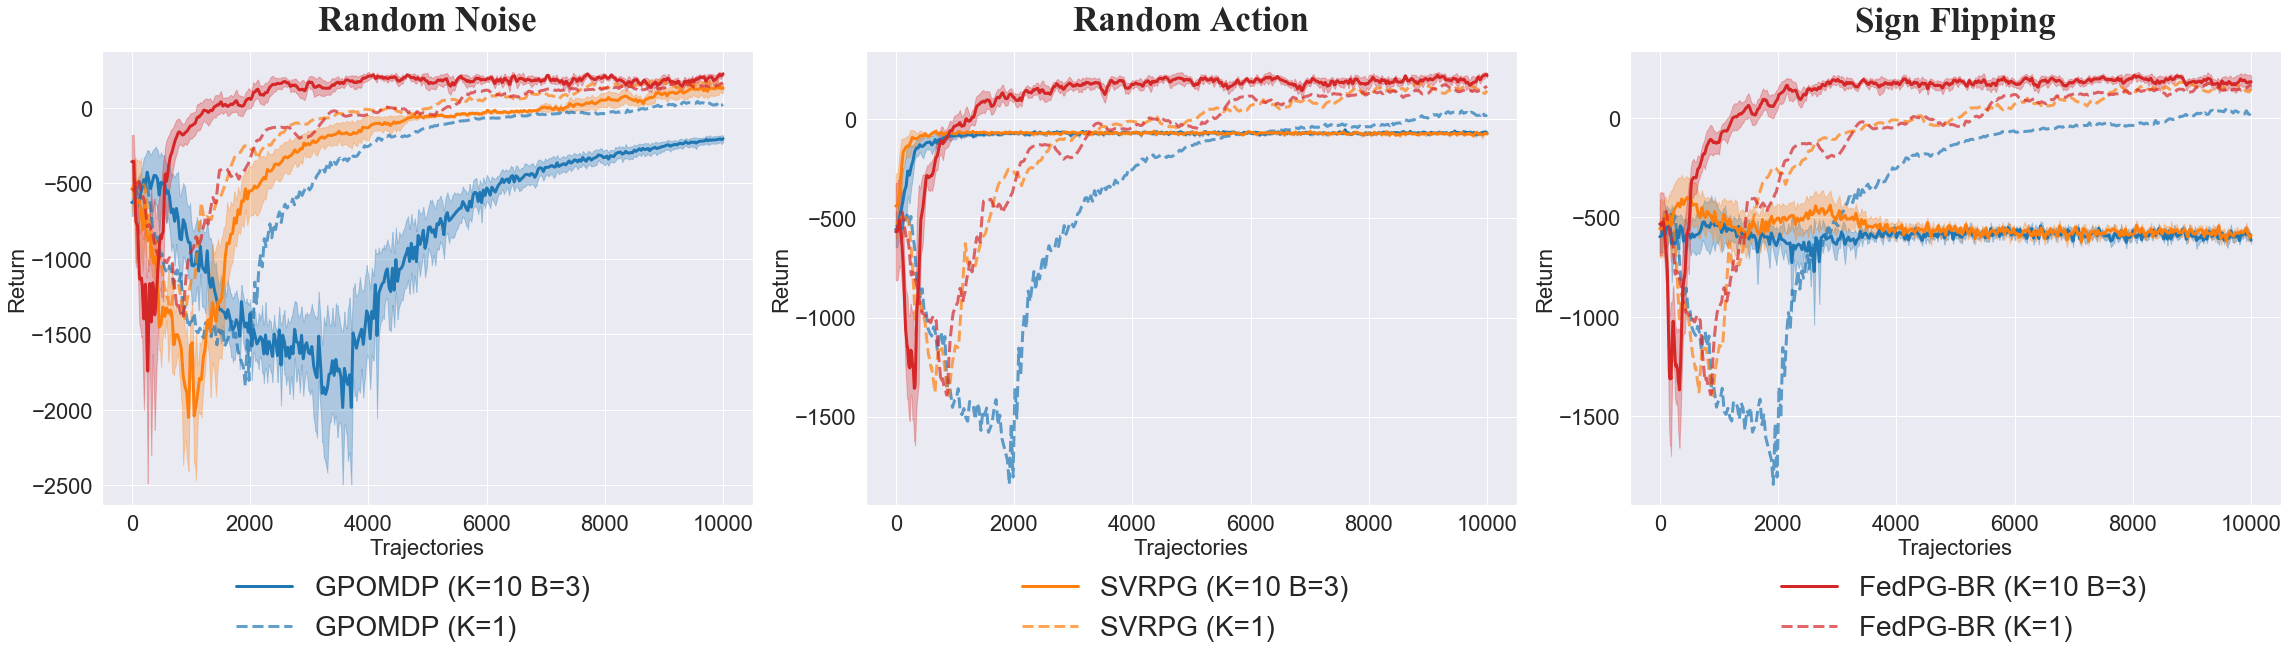

In [129]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(32,8))

colors = [u'#1f77b4', u'#ff7f0e', u'#d62728', u'#d62728', u'#9467bd', u'#8c564b']
# colors =  ['#9467bd', '#d62728', '#e89216'][::-1]
# [u'#1f77b4', u'#ff7f0e', u'#9467bd', u'#2ca02c', u'#d62728', u'#8c564b']

for plot_id in range(3):
    
    dfw = dfws[plot_id]
    max_trajectories = max_trajectories_ls[plot_id]
    
    runs = dfw["run"].unique()
    runs_ordered = []
    runs_ordered_labels = []
    
    
    for i in range(5):
        for name in runs:
            if i == 0 and 'VPG' in name:
                runs_ordered.append(name)
                runs_ordered_labels.append('GPOMDP (K=10 B=3)')
                runs_ordered.append('VPG')
                runs_ordered_labels.append('GPOMDP (K=1)')
            elif i == 1 and 'SVRG' in name:
                runs_ordered.append(name)
                runs_ordered_labels.append('SVRPG (K=10 B=3)')
                runs_ordered.append('SVRG')
                runs_ordered_labels.append('SVRPG (K=1)')
            elif i == 2 and 'Ours' in name and 'W10' in name:
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR (K=10 B=3)')
                runs_ordered.append('Ours')
                runs_ordered_labels.append('FedPG-BR (K=1)')

    
    for idx, run_name in enumerate(runs_ordered):
        if not 'B=3' in runs_ordered_labels[idx]:
            
            dfw_ = dfws[-1]
            cur_dfw = dfw_[dfw_.run.str.contains(f'{run_name}') & dfw_.run.str.contains(f'W1_')]
#             print(runs_ordered_labels[idx], run_name)
            lines = []
            for run_id in range(max_runs):
                steps = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['value'].to_numpy()
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            
            mean = np.mean(lines, axis=0)
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=3., linestyle = 'dashed', alpha = 0.7, color = colors[idx // 2])
            
            
        else:
            
            cur_dfw = dfw[dfw.run.str.endswith(f'{run_name}')]
            lines = []
            for run_id in cur_dfw.tag.unique():
                steps = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['value'].to_numpy()
                if len(steps)<300:
                    continue
                    
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            
            mean = np.mean(lines, axis=0)
            l, h = stats.norm.interval(interval, loc=np.mean(lines, axis = 0), scale=stats.sem(lines, axis = 0))
            
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=3, color = colors[idx // 2])
            axes[plot_id].fill_between(range(int(max_trajectories)), l, h, alpha = 0.3, color = colors[idx // 2])    

            
        axes[plot_id].set_title(ENV_NAMES[plot_id], fontsize=35, 
                                pad=20,
                                fontname='Times New Roman')
        axes[plot_id].tick_params(labelsize=22)
        axes[plot_id].set_xlabel("Trajectories", fontsize=22)
        axes[plot_id].set_ylabel("Return", fontsize=22)
#         axes[plot_id].set_ylim([-2500, 400])
            
            
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
# plt.legend(loc='bottom', 
#            ncol=1, 
#            handlelength=1,
#            mode="expand", 
#            bbox_to_anchor=(1.05, 0, 1,0), borderaxespad=0, prop={'size': 13})
plt.tight_layout(pad=1)
# plt.rcParams["font.family"] = "Times New Roman"

# Shrink current axis's height by 10% on the bottom

length_ = (axes[2].get_position().x1 - axes[0].get_position().x0) / (axes[0].get_position().x1 - axes[0].get_position().x0)

# Put a legend below current axis
plt_lgd = plt.legend(loc='upper left', bbox_to_anchor=(length_ * 0.05, -0.1, length_ * 0.9, 0), bbox_transform=axes[0].transAxes,
         mode = "expand", fancybox=False, shadow=False, ncol=3, fontsize = 28, frameon=False)

plt.savefig('./New-EXP2-HalfCheetah.pdf', format='pdf', dpi=600,
            bbox_extra_artists=(plt_lgd,), bbox_inches='tight')
plt.show()